In [22]:
import pandas as pd
apple_csv = pd.read_csv('Apple.csv')
amazon_csv = pd.read_csv('Amazon.csv')
google_csv = pd.read_csv('Google.csv')
micro_csv = pd.read_csv('Microsoft.csv')
netflix_csv = pd.read_csv('Netflix.csv')

apple_csv.columns = [f'Apple_{col}' if col != 'Date' else 'Date' for col in apple_csv.columns]
amazon_csv.columns = [f'Amazon_{col}' if col != 'Date' else 'Date' for col in amazon_csv.columns]
google_csv.columns = [f'Google_{col}' if col != 'Date' else 'Date' for col in google_csv.columns]
micro_csv.columns = [f'Microsoft_{col}' if col != 'Date' else 'Date' for col in micro_csv.columns]
netflix_csv.columns = [f'Netflix_{col}' if col != 'Date' else 'Date' for col in netflix_csv.columns]

merged_df = apple_csv
merged_df = pd.merge(merged_df, amazon_csv, on='Date', how='outer')
merged_df = pd.merge(merged_df, google_csv, on='Date', how='outer')
merged_df = pd.merge(merged_df, micro_csv, on='Date', how='outer')
merged_df = pd.merge(merged_df, netflix_csv, on='Date', how='outer')

# converts to proper 
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
columns_without_date = merged_df.drop(columns=['Date']).columns.tolist()
merged_df[columns_without_date] = merged_df[columns_without_date].apply(pd.to_numeric, errors='coerce')

# remove rows with missing vals
merged_df.dropna(inplace=True)

# makes date as key
merged_df.set_index('Date', inplace=True)

# removes and duplicate rows
merged_df.drop_duplicates(inplace=True)

# extracts only the years we want
df = merged_df[500:2150]
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Apple_Open,Apple_High,Apple_Low,Apple_Close,Apple_Adj Close,Apple_Volume,Amazon_Open,Amazon_High,Amazon_Low,Amazon_Close,Amazon_Adj Close,Amazon_Volume,Google_Open,Google_High,Google_Low,Google_Close,Google_Adj Close,Google_Volume,Microsoft_Open,Microsoft_High,Microsoft_Low,Microsoft_Close,Microsoft_Adj Close,Microsoft_Volume,Netflix_Open,Netflix_High,Netflix_Low,Netflix_Close,Netflix_Adj Close,Netflix_Volume
0,2006-08-14,2.287500,2.329286,2.271429,2.283571,1.943590,717620400,1.3110,1.3530,1.3090,1.3265,1.3265,102560000,9.252818,9.343229,9.182332,9.201261,9.201261,199476896.0,24.520000,24.600000,24.350000,24.530001,17.597080,47831900,2.842857,2.858571,2.834286,2.844286,2.844286,5253500.0
1,2006-08-15,2.333571,2.375000,2.314286,2.373214,2.019886,861352800,1.3485,1.3930,1.3310,1.3885,1.3885,164032000,9.317825,9.506119,9.280215,9.488684,9.488684,268932260.0,24.549999,24.650000,24.440001,24.620001,17.726677,48994500,2.862857,2.900000,2.830000,2.850000,2.850000,6462400.0
2,2006-08-16,2.396429,2.431071,2.368929,2.427857,2.066394,781284000,1.3985,1.4070,1.3760,1.3975,1.3975,152732000,9.551200,9.674986,9.517327,9.656804,9.656804,235005569.0,24.610001,24.730000,24.469999,24.700001,17.784285,52373600,2.860000,2.877143,2.795714,2.824286,2.824286,10453800.0
3,2006-08-17,2.428571,2.452143,2.399286,2.413929,2.054539,581148400,1.3980,1.4875,1.3915,1.4545,1.4545,189926000,9.623678,9.713591,9.562159,9.608983,9.608983,203969673.0,24.700001,24.750000,24.610001,24.700001,17.784285,45674800,2.800000,2.951429,2.798571,2.861429,2.861429,9569700.0
4,2006-08-18,2.418214,2.442857,2.402143,2.425357,2.064267,536354000,1.4545,1.4615,1.4110,1.4560,1.4560,119972000,9.621686,9.641113,9.483205,9.548211,9.548211,198830482.0,25.049999,25.799999,24.980000,25.790001,18.569094,128414800,2.871429,2.890000,2.824286,2.835714,2.835714,5793900.0


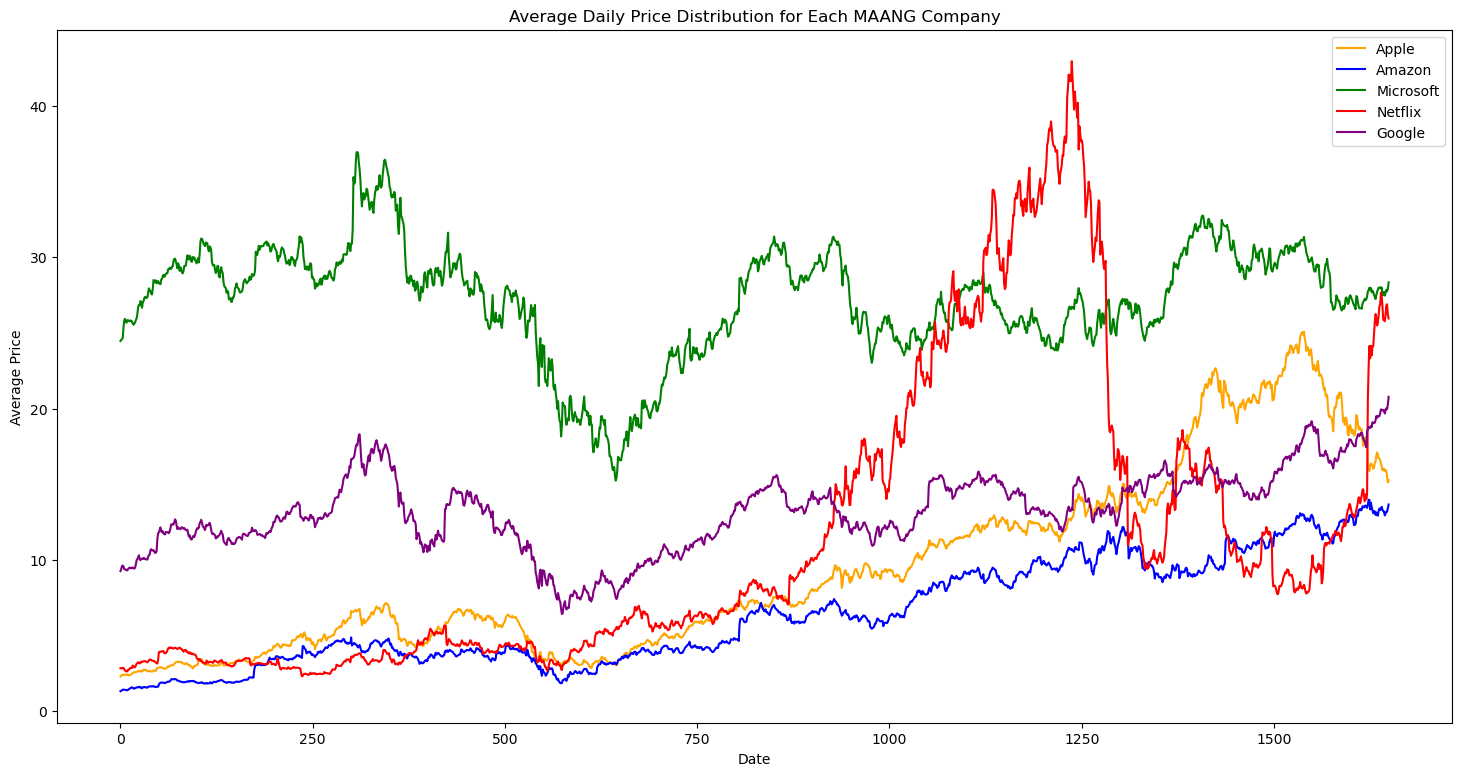

In [23]:
# Line Plot
import matplotlib.pyplot as plt

# dict of companies to line colors
companies = {
    'Apple': 'orange',
    'Amazon': 'blue',
    'Microsoft': 'green',
    'Netflix': 'red',
    'Google': 'purple'
}

# iterates and extracts the company averages per day
for company in companies.keys():
    df[f'{company}_Avg'] = (df[f'{company}_High'] + df[f'{company}_Low']) / 2

# plots the indv company average distributions
plt.figure(figsize=(18, 9))
for company, color in companies.items():
    plt.plot(df.index, df[f'{company}_Avg'], label=company, color=color)

# label and title
plt.title('Average Daily Price Distribution for Each MAANG Company')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [24]:
# Creating the line plot in D3 instead
df.to_csv('maang_data.csv', index=True)

In [15]:
# Area Graph for Total Monthly Volume
import altair as alt

volume_cols = ['Apple_Volume', 'Amazon_Volume', 'Google_Volume', 'Microsoft_Volume', 'Netflix_Volume']

# New dataframe with only monthly total volume for each company per year
# REFERENCE https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html
df_monthly = df.groupby(pd.Grouper(key='Date', freq='ME')).sum()[volume_cols].reset_index()

# Selection element
selection = alt.selection_point(fields = ['Company'])

color = alt.condition(
    selection,
    alt.Color('Company:N', scale=alt.Scale(domain=volume_cols, range=list(companies.values()))).legend(None),
    alt.value(None)
)

# Area Graph
area = alt.Chart(df_monthly).transform_fold(
    volume_cols, 
    as_=['Company', 'Volume']
).mark_area(opacity=0.6).encode(
    alt.X('yearmonth(Date):T', title='Year & Month', axis=alt.Axis(format='%Y-%b')),
    alt.Y('Volume:Q', title='Total Volume of Shares', stack=None),
    color = color
).properties(
    title='Total Monthly Volume of Shares Per MAANG Company',
    width=800,
    height=400
).add_params(
    selection  
)

# Interactive Legend
legend = alt.Chart(df_monthly).transform_fold(
    volume_cols, 
    as_=['Company', 'Volume']
).mark_rect().encode(
    alt.Y('Company:N', axis=alt.Axis(orient='right')),  # Correctly reference the Company field
    color=color  # Apply the color condition to the legend as well
).add_params(
    selection
)

area | legend

alt.HConcatChart(...)

In [16]:
# Data pre-processing for google search trends data
trends = pd.read_csv('trends.csv')

# Filtering for the US between 2006 and 2013
trends = trends[(trends['location'] == 'United States') & (trends['year'].isin(range(2006, 2014)))]
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)
trends
# checking what categories exist
# print(trends['category'].unique())
# Scandals, Lawsuits, Presidential Campaign, It's the Economy, Google.com Fastest Falling, Google Maps Searches, Google News Searches, Google.com Fastest Rising, Donate To, News Searches, Product Searches, Searches, Economy, Gadgets, Political Scandals, Politics, Technology, Election Issues, Stocks, Tech Gadgets, US Politicians, Events, New York City, NY

,location,year,category,rank,query
540,United States,2006,Movie Showtimes,1,Idiocracy Showtimes
541,United States,2006,Movie Showtimes,2,Cars Showtimes
542,United States,2006,Movie Showtimes,3,Borat Showtimes
543,United States,2006,Movie Showtimes,4,Superman Showtimes
544,United States,2006,Movie Showtimes,5,Jesus Camp Showtimes
545,United States,2006,Scandals,1,Duke Lacrosse Scandal
546,United States,2006,Scandals,2,Project Runway Scandal
547,United States,2006,Scandals,3,Duke Scandal
548,United States,2006,Scandals,4,Duke Rape Scandal
549,United States,2006,Scandals,5,Reggie Bush Scandal


In [17]:
# Top three searches per desired category per year
desired_categories = ["Scandals", "Lawsuits", "Presidential Campaign", "It's the Economy", "Google.com Fastest Falling", 
                      "Google Maps Searches", "Google News Searches", "Google.com Fastest Rising", "Donate To", "News Searches", 
                      "Product Searches", "Searches", "Economy", "Gadgets", "Political Scandals", "Politics", "Technology", 
                      "Election Issues", "Stocks", "Tech Gadgets", "US Politicians", "Events", "New York City, NY"]

trends_top = trends[trends['rank'].isin(range(1,4))]
trends_top = trends_top[trends_top['category'].isin(desired_categories)]
trends_top

,location,year,category,rank,query
545,United States,2006,Scandals,1,Duke Lacrosse Scandal
546,United States,2006,Scandals,2,Project Runway Scandal
547,United States,2006,Scandals,3,Duke Scandal
580,United States,2007,Lawsuits,1,Borat Lawsuit
581,United States,2007,Lawsuits,2,Vonage Lawsuit
582,United States,2007,Lawsuits,3,iPhone Lawsuit
590,United States,2007,Presidential Campaign,1,Ron Paul
591,United States,2007,Presidential Campaign,2,Fred Thompson
592,United States,2007,Presidential Campaign,3,Hilary Clinton
1505,United States,2008,It's the Economy,1,Financial Crisis


In [18]:
trends_top['Year'] = trends_top['year']
# Aggregate trends data by year and category to get a count of search entries
trends_summary = trends_top.groupby(['Year', 'category']).size().reset_index(name='search_count')

# Optionally, aggregate by rank to create a weighted score (lower rank = higher impact)
trends_summary['weighted_score'] = trends_top.groupby(['Year', 'category'])['rank'].mean().values
trends_summary.head()

,Year,category,search_count,weighted_score
0,2006,Scandals,3,2.0
1,2007,Lawsuits,3,2.0
2,2007,Presidential Campaign,3,2.0
3,2008,It's the Economy,3,2.0
4,2009,Google.com Fastest Falling,3,2.0


In [19]:
price_cols = ['Apple_High', 'Apple_Low', 'Apple_Close', 
              'Amazon_High', 'Amazon_Low', 'Amazon_Close',
              'Google_High', 'Google_Low', 'Google_Close',
              'Microsoft_High', 'Microsoft_Low', 'Microsoft_Close',
              'Netflix_High', 'Netflix_Low', 'Netflix_Close']

# Dataframe of yearly total volume and average prices
df_yearly_volume = df.groupby(pd.Grouper(key='Date', freq='YE')).sum()[volume_cols].reset_index()
df_yearly_prices = df.groupby(pd.Grouper(key='Date', freq='YE')).mean()[price_cols].reset_index()
df_yearly = pd.merge(df_yearly_volume, df_yearly_prices, on='Date')

# Extract the year from the Date column
df_yearly['Year'] = df_yearly['Date'].dt.year
df_yearly.drop(columns=['Date'], inplace=True)

df_yearly

,Apple_Volume,Amazon_Volume,Google_Volume,Microsoft_Volume,Netflix_Volume,Apple_High,Apple_Low,Apple_Close,Amazon_High,Amazon_Low,Amazon_Close,Google_High,Google_Low,Google_Close,Microsoft_High,Microsoft_Low,Microsoft_Close,Netflix_High,Netflix_Low,Netflix_Close,Year
0,72091888400,14264632000,2.212780e+10,5513016600,8.018696e+08,2.843015,2.775184,2.811403,1.782438,1.731139,1.759866,11.042974,10.841233,10.939329,28.130722,27.773196,27.979691,3.591856,3.491370,3.538616,2006
1,246995985600,48954882000,5.481235e+10,15661695600,2.836394e+09,4.645374,4.506589,4.581211,3.407827,3.305508,3.361474,13.553615,13.275141,13.418465,30.727689,30.156932,30.446773,3.178617,3.066096,3.123933,2007
2,285981206000,50384174000,6.421449e+10,21296026200,2.800814e+09,5.182524,4.959204,5.070679,3.588350,3.401854,3.494002,11.814250,11.374182,11.577904,27.132411,26.235336,26.647391,4.199983,3.981875,4.094670,2008
3,143253686800,42916886000,3.550490e+10,15732659600,2.904000e+09,5.303417,5.177317,5.243362,4.428938,4.284312,4.364091,11.058242,10.821192,10.951161,23.246984,22.673730,22.976786,6.434314,6.188855,6.322035,2009
4,151024927200,36739730000,3.217359e+10,15892924000,7.126840e+09,9.370315,9.173129,9.280088,7.045464,6.849831,6.957020,13.473203,13.220146,13.340574,27.322143,26.793254,27.058571,17.138815,16.460249,16.824172,2010
5,124059339600,29199572000,3.114476e+10,15292282000,1.118585e+10,13.122270,12.867775,13.000154,9.973744,9.677419,9.833601,14.305521,14.037592,14.171237,26.296825,25.790476,26.052341,28.021151,26.951270,27.493719,2011
6,131964204400,20998082000,2.614137e+10,11984490100,1.021595e+10,20.779479,20.354327,20.573204,11.133972,10.879442,11.015182,16.146392,15.864414,16.010401,30.058800,29.570520,29.820960,12.124200,11.574623,11.855057,2012
7,24241095200,3259686000,4.325782e+09,2040080800,1.849083e+09,17.188970,16.787475,16.956229,13.494721,13.159651,13.326349,19.137773,18.850848,19.008501,27.721395,27.300465,27.506977,22.012159,20.918605,21.515880,2013


In [20]:
df_yearly_avg = df_yearly.groupby('Year').mean().reset_index()
df_yearly_avg.head()

,Year,Apple_Volume,Amazon_Volume,Google_Volume,Microsoft_Volume,Netflix_Volume,Apple_High,Apple_Low,Apple_Close,Amazon_High,Amazon_Low,Amazon_Close,Google_High,Google_Low,Google_Close,Microsoft_High,Microsoft_Low,Microsoft_Close,Netflix_High,Netflix_Low,Netflix_Close
0,2006,7.209189e+10,1.426463e+10,2.212780e+10,5.513017e+09,8.018696e+08,2.843015,2.775184,2.811403,1.782438,1.731139,1.759866,11.042974,10.841233,10.939329,28.130722,27.773196,27.979691,3.591856,3.491370,3.538616
1,2007,2.469960e+11,4.895488e+10,5.481235e+10,1.566170e+10,2.836394e+09,4.645374,4.506589,4.581211,3.407827,3.305508,3.361474,13.553615,13.275141,13.418465,30.727689,30.156932,30.446773,3.178617,3.066096,3.123933
2,2008,2.859812e+11,5.038417e+10,6.421449e+10,2.129603e+10,2.800814e+09,5.182524,4.959204,5.070679,3.588350,3.401854,3.494002,11.814250,11.374182,11.577904,27.132411,26.235336,26.647391,4.199983,3.981875,4.094670
3,2009,1.432537e+11,4.291689e+10,3.550490e+10,1.573266e+10,2.904000e+09,5.303417,5.177317,5.243362,4.428938,4.284312,4.364091,11.058242,10.821192,10.951161,23.246984,22.673730,22.976786,6.434314,6.188855,6.322035
4,2010,1.510249e+11,3.673973e+10,3.217359e+10,1.589292e+10,7.126840e+09,9.370315,9.173129,9.280088,7.045464,6.849831,6.957020,13.473203,13.220146,13.340574,27.322143,26.793254,27.058571,17.138815,16.460249,16.824172


In [21]:
# Merge the aggregated trends data with the stock data
merged_data = pd.merge(df_yearly_avg, trends_summary, on='Year', how='left')

merged_data

,Year,Apple_Volume,Amazon_Volume,Google_Volume,Microsoft_Volume,Netflix_Volume,Apple_High,Apple_Low,Apple_Close,Amazon_High,Amazon_Low,Amazon_Close,Google_High,Google_Low,Google_Close,Microsoft_High,Microsoft_Low,Microsoft_Close,Netflix_High,Netflix_Low,Netflix_Close,category,search_count,weighted_score
0,2006,7.209189e+10,1.426463e+10,2.212780e+10,5.513017e+09,8.018696e+08,2.843015,2.775184,2.811403,1.782438,1.731139,1.759866,11.042974,10.841233,10.939329,28.130722,27.773196,27.979691,3.591856,3.491370,3.538616,Scandals,3.0,2.0
1,2007,2.469960e+11,4.895488e+10,5.481235e+10,1.566170e+10,2.836394e+09,4.645374,4.506589,4.581211,3.407827,3.305508,3.361474,13.553615,13.275141,13.418465,30.727689,30.156932,30.446773,3.178617,3.066096,3.123933,Lawsuits,3.0,2.0
2,2007,2.469960e+11,4.895488e+10,5.481235e+10,1.566170e+10,2.836394e+09,4.645374,4.506589,4.581211,3.407827,3.305508,3.361474,13.553615,13.275141,13.418465,30.727689,30.156932,30.446773,3.178617,3.066096,3.123933,Presidential Campaign,3.0,2.0
3,2008,2.859812e+11,5.038417e+10,6.421449e+10,2.129603e+10,2.800814e+09,5.182524,4.959204,5.070679,3.588350,3.401854,3.494002,11.814250,11.374182,11.577904,27.132411,26.235336,26.647391,4.199983,3.981875,4.094670,It's the Economy,3.0,2.0
4,2009,1.432537e+11,4.291689e+10,3.550490e+10,1.573266e+10,2.904000e+09,5.303417,5.177317,5.243362,4.428938,4.284312,4.364091,11.058242,10.821192,10.951161,23.246984,22.673730,22.976786,6.434314,6.188855,6.322035,Google.com Fastest Falling,3.0,2.0
5,2009,1.432537e+11,4.291689e+10,3.550490e+10,1.573266e+10,2.904000e+09,5.303417,5.177317,5.243362,4.428938,4.284312,4.364091,11.058242,10.821192,10.951161,23.246984,22.673730,22.976786,6.434314,6.188855,6.322035,Google.com Fastest Rising,3.0,2.0
6,2009,1.432537e+11,4.291689e+10,3.550490e+10,1.573266e+10,2.904000e+09,5.303417,5.177317,5.243362,4.428938,4.284312,4.364091,11.058242,10.821192,10.951161,23.246984,22.673730,22.976786,6.434314,6.188855,6.322035,News Searches,3.0,2.0
7,2010,1.510249e+11,3.673973e+10,3.217359e+10,1.589292e+10,7.126840e+09,9.370315,9.173129,9.280088,7.045464,6.849831,6.957020,13.473203,13.220146,13.340574,27.322143,26.793254,27.058571,17.138815,16.460249,16.824172,NaN,NaN,NaN
8,2011,1.240593e+11,2.919957e+10,3.114476e+10,1.529228e+10,1.118585e+10,13.122270,12.867775,13.000154,9.973744,9.677419,9.833601,14.305521,14.037592,14.171237,26.296825,25.790476,26.052341,28.021151,26.951270,27.493719,Donate To,3.0,2.0
9,2011,1.240593e+11,2.919957e+10,3.114476e+10,1.529228e+10,1.118585e+10,13.122270,12.867775,13.000154,9.973744,9.677419,9.833601,14.305521,14.037592,14.171237,26.296825,25.790476,26.052341,28.021151,26.951270,27.493719,Economy,3.0,2.0
